# Predict Volume of Pharmacy Claims and Prior Authorization Requests

In this notebook, we predict the volume of pharmacy claims and PA requests by month. We also assess the statistical significance of our results. 

In [608]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from warnings import simplefilter
from statsmodels.tools.sm_exceptions import ConvergenceWarning
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=ConvergenceWarning)

## Load and prepare data

In [609]:
# Load Data
df_date=pd.read_csv("data/dim_date.csv")
df_claim=pd.read_csv("data/dim_claims.csv")
df_pa=pd.read_csv("data/dim_pa.csv")
df_bridge=pd.read_csv("data/bridge.csv")

# Clean data so all reject_code values are integers
df_claim['reject_code'] = df_claim.reject_code.fillna(0).astype(int)

# Merge the data frames
df_main = pd.merge(df_claim, df_bridge, on='dim_claim_id')
df_main = pd.merge(df_main, df_pa, how='left', on='dim_pa_id')
df_main = pd.merge(df_main, df_date, how='left', on='dim_date_id')

# split the data frames into two -- PA requested or not
df_main_wPA = df_main[~np.isnan(df_main.pa_approved)].copy()
df_main_noPA = df_main[np.isnan(df_main.pa_approved)].copy()

In [610]:
df_main.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,417380,A,75,0,1.0,1,1.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
1,2,999001,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
2,3,417740,A,76,0,2.0,1,1.0,0.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
3,4,999001,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
4,5,417740,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1


## Volume of Pharmacy Claims

In [611]:
claim_month = df_main_wPA.groupby(['calendar_year', 'calendar_month']).size()
claim_month = pd.DataFrame(claim_month, columns=['claims']).reset_index()
claim_month = claim_month.rename(columns={'calendar_year': 'year', 'calendar_month': 'month'})

We are going to add some features to the above table: `days` for the number of days in the month, `weekdays` for the number of weekdays in the month and etc.

In [612]:
df_feats = df_date.groupby(['calendar_year', 'calendar_month']).agg(
    days=('calendar_day', 'count'),
    weekdays=('is_weekday', 'sum'),
    workdays=('is_workday', 'sum'),
    holidays=('is_holiday', 'sum')
).reset_index().rename(
    columns={
        'calendar_year': 'year',
        'calendar_month': 'month'
    }
)

claim_month = pd.merge(claim_month, df_feats, on=['year', 'month'], how='left')
cols = claim_month.columns.to_list()
cols.remove('claims')
cols.append('claims')
claim_month = claim_month[cols]
claim_month.head()

,year,month,days,weekdays,workdays,holidays,claims
0,2017,1,31,22,21,1,13766
1,2017,2,28,20,20,0,12769
2,2017,3,31,23,23,0,14694
3,2017,4,30,20,20,0,12742
4,2017,5,31,23,22,1,13717


Below, we visualize the number of prior authorization forms filed each year per month.

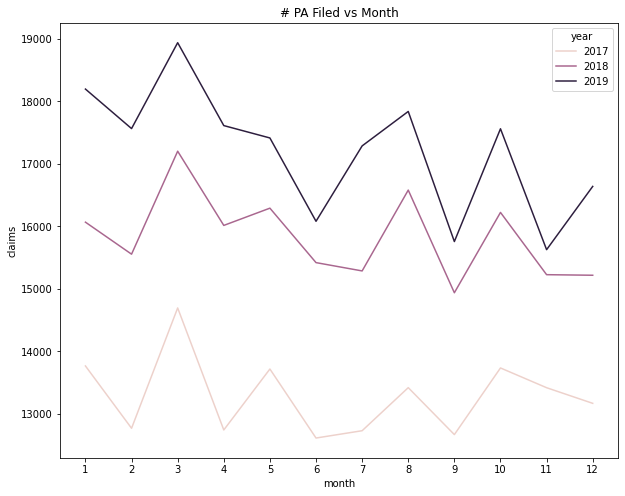

In [613]:
plt.figure(figsize=(10, 8))

sns.lineplot(x='month', y='claims', data=claim_month, hue='year')

plt.title('# PA Filed vs Month')
plt.xticks(range(1, 13), range(1, 13))
plt.show()

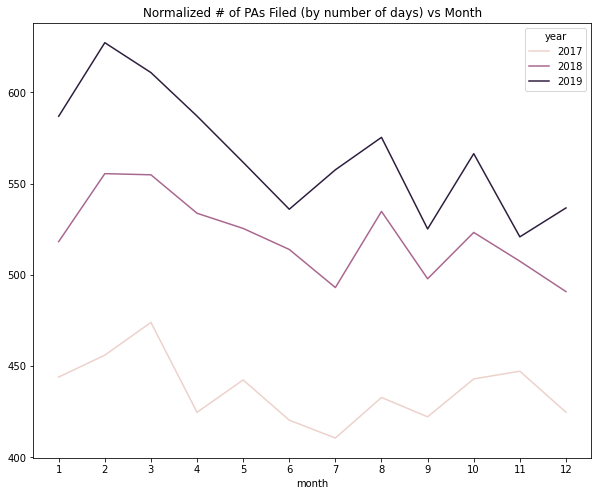

In [614]:
plt.figure(figsize=(10, 8))

sns.lineplot(x=claim_month.month, y=claim_month.claims / claim_month.days, hue=claim_month.year)

plt.title('Normalized # of PAs Filed (by number of days) vs Month')
plt.xticks(range(1, 13), range(1, 13))
plt.show()

It seems that the total volume of PAs filed is increasing by year. This longer term change is referred to as the trend of the data. Additionally, it seems as if there is a higher number of PAs filed at the start of the year and then the volume per month oscillates. This shorter term change is referred to as the seasonality of the data.

We seek a method of time series analysis that captures these features and allows us to forcast the number of PAs filed in the future. **We choose to work with the normalized number of claims per month, but we could easily change this by switching the data.**

In [622]:
months = pd.to_datetime(claim_month.year.astype(str) + '-' + claim_month.month.astype(str))

normalized_claims = claim_month.claims / claim_month.days


## Data for normalized # claims per month ##
X_train = normalized_claims[:-horizon]
X_test = normalized_claims[-horizon:]

## Data for unadjusted # of claims per month ##
#X_train = claim_month[:-horizon]
#X_test = claim_month[-horizon:]



## Exponential Smoothing
Exponential smoothing is a method for creating a time series forecast from previous data, where the previous data is assigned an exponentially decreasing weight with age. In other words, recent observations are given more weight in forecasting than the older ones.

More precisely, suppose that the data sequence is given by $\{x_t\}_{t=0}^N$. In the case of the number of PAs filed, $t=0, \dots, 35$ and is the month and $x_t$ is the number of PAs filed in month $t$. If $s_t$ is our prediction via the exponential smoothing algorithm, then the simplest form of exponential smoothing is given by the formulas: 
\begin{align*} s_0 & = x_0 \\
s_t & = \alpha x_t + (1-\alpha)s_{t-1},
\end{align*}
with $t > 0$ and $\alpha$ a smoothing factor with $0 < \alpha < 1$. 




In [616]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

The number of units that we want to predict into the future is referred to as the forcast horizon. Since the time unit we choose to work with is in months, our forcast horizon represents the number of months for which we predict the number of PAs filed into the future.

In [617]:
horizon = 6

### Constructing Prediction Intervals

A prediction interval is an interval within which we expect a value $x$ to lie with a specified probability. In particular, we would like to measure the statistical significance of our forcast. 

Note that while prediction intervals are similar to confidence intervals, they are not the same. Confidence intervals are estimates that are calculated from sample data to determine intervals that are likely to contain the population parameter. On the other hand, a prediction interval is an interval that likely contains the value of a dependent variable for a new observation, given other values of the independent variable. 

The procedure for constructing confidence intervals and prediction intervals are similar. More precisely, we do the following:
1. Simulate the data N times from a state space determined by the data;
2. from each simulation, create a forcast;
3. take the middle $95$% of forecast values to create a $95$% prediction interval. 

The prediction intervals will be constructed via `statsmodels.tsa.simulate`. This model assumes that the true value of $x$ at time $t$ is randomly distributed around the prediction value with the error following a normal distribution. We can choose two models determined by the error. Denote the prediction at time $t$ to be $\hat x_{t|t-1}$ and the true value to be $x_t$.

1. The additive error model: 
\begin{align*} x_t & = \hat x_{t|t-1} + e_t \\
e_t & \sim \mathcal N(0, \sigma^2).
\end{align*}
2. The multiplicative error model: 
\begin{align*} x_t & = \hat x_{t|t-1}\big(1+ e_t \big) \\
e_t & \sim \mathcal N(0, \sigma^2).
\end{align*}

In this analysis, the variance $\sigma$ is determined automatically from the fit errors resulting from numpy's random number generator. 

**We choose the error model empirically and find the the additive error model is a better fit for our data.**  

Below, we write the functions needed to fit and plot the models, as well as the function needed to construct the confidence intervals from the simulations. 

In [618]:
def create_pi(sims, alpha):
    # sims is a pd series that contains simulation data in each column with the month in each row. 
    num_months = np.shape(sims)[0]
    num_sims=np.shape(sims)[1]
    con_ints=np.zeros((num_months,4))
    for i in range(0, num_months):
        data=sims.loc[36-num_months+i]
        p = ((1.0-alpha)/2.0) * 100
        con_ints[i,0] = np.percentile(data, p)
        p = (alpha+((1.0-alpha)/2.0)) * 100
        con_ints[i,1]=np.percentile(data, 50)
        con_ints[i,2] = np.percentile(data, p)
        con_ints[i,3]=36-num_months+i
    new_df=pd.DataFrame(data=con_ints, columns=['lower_bound', 'middle', 'upper_bound', 'month'] )
    return new_df


In [619]:
def fit_and_plot(model_cls, sims = False, **kwargs):
    model = model_cls(X_train, **kwargs).fit()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    
    ax.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    ax.plot(
        months[-horizon-1:],
        [model.fittedvalues.tolist()[-1]] + model.forecast(horizon).tolist(),
        'r--', label='test forecast'
    )
    

    
    plt.title(model_cls.__name__)
    plt.legend()
    plt.show()
    
    train_mse = mean_squared_error(X_train, model.fittedvalues)
    test_mse = mean_squared_error(X_test, model.forecast(horizon))
    print(f'Train MSE for {model_cls.__name__}: {train_mse:.2f}')
    print(f'Test MSE for {model_cls.__name__}: {test_mse:.2f}')
    
    return model

def fit_and_plot_uncertainty(model_cls, alpha, **kwargs):
    model = model_cls(X_train, **kwargs).fit()
    start=len(months)-horizon
    simulations = model.simulate(horizon, repetitions=500, anchor=start, error='mul')
    pred_int=create_pi(simulations, alpha)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    
    ax.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    ax.plot(
        months[-horizon-1:],
        [model.fittedvalues.tolist()[-1]] + model.forecast(horizon).tolist(),
        'r--', label='test forecast'
    )
    
    connection=[X_train.tolist()[-1]]
    
    if model_cls==ARIMA:
        ax.plot(months[start-1:], connection+ simulations['y',0].tolist(), 
                '-', alpha=0.07, color='grey', label='Simulation') 
        for i in range(1, 100):
            ax.plot(months[start-1:],connection+ simulations['y',i].tolist(), 
                    '-', alpha=0.07, color='grey')     
    else:
        ax.plot(months[start-1:], connection+ simulations[0].tolist(), 
                '-', alpha=0.07, color='grey', label='simulation')
        for i in range(1, 100):
            ax.plot(months[start-1:], connection+ simulations[i].tolist(), 
                    '-', alpha=0.07, color='grey')
    
    lb=connection+pred_int['lower_bound'].tolist()
    ub=connection+pred_int['upper_bound'].tolist()
    mid=connection+pred_int['middle'].tolist()
    ax.plot(months[start-1:], lb, '--', color='purple', alpha=.5)
    ax.plot(months[start-1:], ub, '--', color='purple', alpha=.5)
    ax.plot(months[start-1:], mid , '--', color='purple', alpha=.5)
    ax.fill_between(months[start-1:], lb , ub , alpha=.05, label='{} Prediction Interval'.format(alpha), color='purple')
    
    plt.title(model_cls.__name__)
    plt.legend()
    plt.show()
    
    train_mse = mean_squared_error(X_train, model.fittedvalues)
    test_mse = mean_squared_error(X_test, model.forecast(horizon))
    PI_u_mse = mean_squared_error(X_test,pred_int['upper_bound'].tolist())
    PI_l_mse=mean_squared_error(X_test,pred_int['lower_bound'].tolist()) 
    
    print(f'Train MSE for {model_cls.__name__}: {train_mse:.2f}')
    print(f'Test MSE for {model_cls.__name__}: {test_mse:.2f}')
    print(f'Upper Bound Prediction Interval MSE for {model_cls.__name__}: {PI_u_mse:.2f}')
    print(f'Lower Bound Prediction Interval MSE for {model_cls.__name__}: {PI_l_mse:.2f}')
    print(np.round(np.sqrt(PI_u_mse)/np.mean(X_train.tolist()[-horizon:])*100,2))
    return model

In [620]:
def fit_and_plot_both(model_cls, alpha = .95, **kwargs):
    model = model_cls(X_train, **kwargs).fit()
    start=len(months)-horizon
    simulations = model.simulate(horizon, repetitions=500, anchor=start, error='add')
    pred_int=create_pi(simulations, alpha)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 8))
    
    # first plot
    ax1.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax1.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    
    ax1.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    ax1.plot(
        months[-horizon-1:],
        [model.fittedvalues.tolist()[-1]] + model.forecast(horizon).tolist(),
        'r--', label='test forecast'
    )
    
    ax1.set_title('forecast')
    
    ax1.tick_params(axis='x', labelrotation = 45)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('# PAs Filed')
    
    ax1.legend()
    
    # second plot
    ax2.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax2.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    ax2.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    
    connection=[model.fittedvalues.tolist()[-1]]
    
    if model_cls==ARIMA:
        ax2.plot(months[start-1:], connection+ simulations['y',0].tolist(), 
                '-', alpha=0.07, color='grey', label='Simulation') 
        for i in range(1, 100):
            ax2.plot(months[start-1:],connection+ simulations['y',i].tolist(), 
                    '-', alpha=0.07, color='grey')     
    else:
        ax2.plot(months[start-1:], connection+ simulations[0].tolist(), 
                '-', alpha=0.07, color='grey', label='simulation')
        for i in range(1, 100):
            ax2.plot(months[start-1:], connection+ simulations[i].tolist(), 
                    '-', alpha=0.07, color='grey')
    
    lb=connection+pred_int['lower_bound'].tolist()
    ub=connection+pred_int['upper_bound'].tolist()
    mid=connection+pred_int['middle'].tolist()
    ax2.plot(months[start-1:], lb, '--', color='purple', alpha=.5)
    ax2.plot(months[start-1:], ub, '--', color='purple', alpha=.5)
    ax2.plot(months[start-1:], mid , '--', color='purple', alpha=.5)
    ax2.fill_between(months[start-1:], lb , ub , alpha=.05, label='{} Prediction Interval'.format(alpha), color='purple')
    ax2.tick_params(axis='x', labelrotation = 45)
    ax2.legend()
    ax2.set_title('forecast Prediction Interval')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('# PAs Filed')
    
    fig.suptitle(model_cls.__name__)
    
    
    # print errors 
    
    train_mse = mean_squared_error(X_train, model.fittedvalues)
    test_mse = mean_squared_error(X_test, model.forecast(horizon))
    PI_u_mse = mean_squared_error(X_test,pred_int['upper_bound'].tolist())
    PI_l_mse=mean_squared_error(X_test,pred_int['lower_bound'].tolist()) 
    
    print(f'Train MSE for {model_cls.__name__}: {train_mse:.2f}')
    print(f'Test MSE for {model_cls.__name__}: {test_mse:.2f}')
    print(f'Upper Bound Prediction Interval MSE for {model_cls.__name__}: {PI_u_mse:.2f}')
    print(f'Lower Bound Prediction Interval MSE for {model_cls.__name__}: {PI_l_mse:.2f}')
    
    avg_error = (np.round(np.sqrt(PI_u_mse)/np.mean(X_train.tolist()[-horizon:])*100,2) + np.round(np.sqrt(PI_l_mse)/np.mean(X_train.tolist()[-horizon:])*100,2))/2
    
    avg_error=np.round(avg_error, 2)
    print()
    print('---------------------------------------------------------')
    print('There is a', alpha*100, '% chance that our forecast will be within', avg_error, '% of the true # of PAs filed monthly.')
    
    

### Simple Exponential Smoothing
With simple exponential smoothing, we estimate the value of $x$ at time $T+1$ by forming a weighted average of the previous values. If $0 \leq \alpha \leq 1$ is the smoothing parameter, then we can write 
\begin{align*} \hat x_{T+1|T} & = \alpha x_T + \alpha (1-\alpha) x_{T-1} + \alpha(1-\alpha)^2 x_{T-2} + \dots \\
& = \sum_{j = 0}^T \alpha (1-\alpha)^{T-j} x_j.
\end{align*}
This model is only appropriate when there are no trends or seasonality in the data. From the previous discussion, this means we. do not expect this model to be great, but will be useful as a baseline. 

Train MSE for SimpleExpSmoothing: 1126.80
Test MSE for SimpleExpSmoothing: 533.14
Upper Bound Prediction Interval MSE for SimpleExpSmoothing: 14659.62
Lower Bound Prediction Interval MSE for SimpleExpSmoothing: 15497.23

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 20.99 % of the true # of PAs filed monthly.


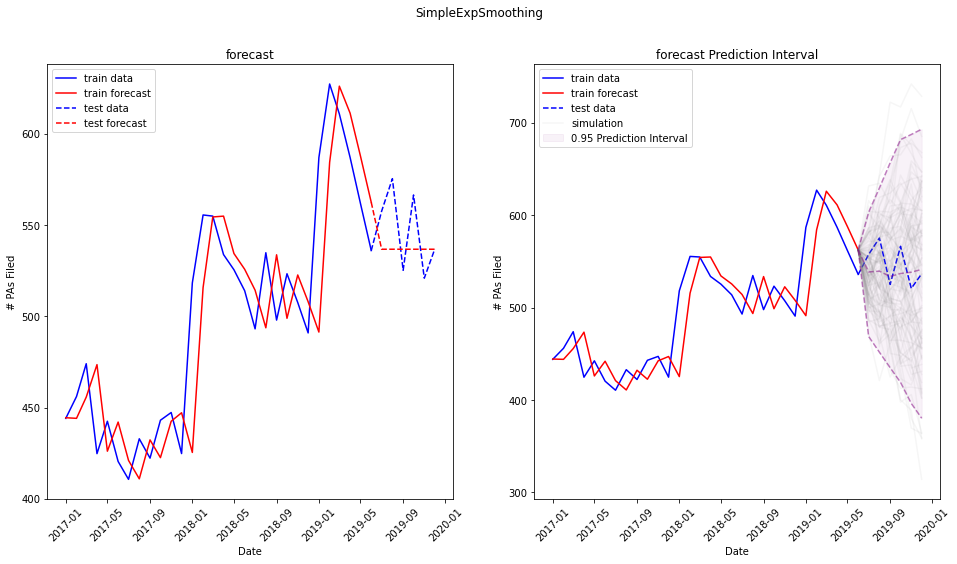

In [623]:
fit_and_plot_both(SimpleExpSmoothing, alpha= .95)

### Holt's Method
Holt's method is a restricted form of exponential smoothing which can capture trends in data but not seasonality. In particular, this model captures an additive or multiplicative trend that can be damped or undamped. A damped trend approaches a constant value at some time in the future. 

See the appendix for the mathematics of this model. 

Similar to the simple exponential smoothing model given above, we do not expect Holt's method to give us a great result since our data displays seasonality. 

Train MSE for Holt: 1116.23
Test MSE for Holt: 579.77
Upper Bound Prediction Interval MSE for Holt: 19626.77
Lower Bound Prediction Interval MSE for Holt: 14312.18

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 22.2 % of the true # of PAs filed monthly.


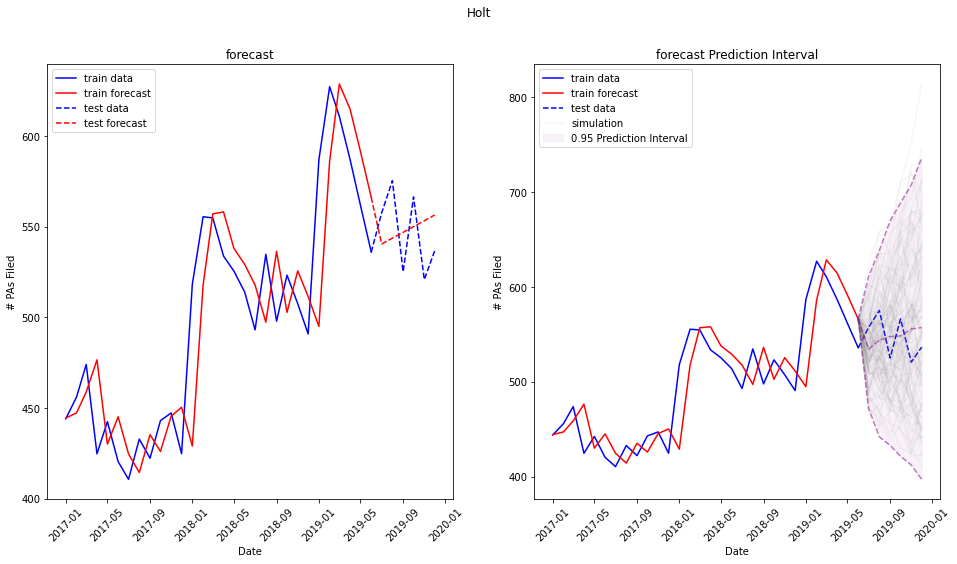

In [624]:
fit_and_plot_both(Holt, damped_trend=False)

Train MSE for Holt: 1115.73
Test MSE for Holt: 533.53
Upper Bound Prediction Interval MSE for Holt: 16692.06
Lower Bound Prediction Interval MSE for Holt: 15105.33

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 21.55 % of the true # of PAs filed monthly.


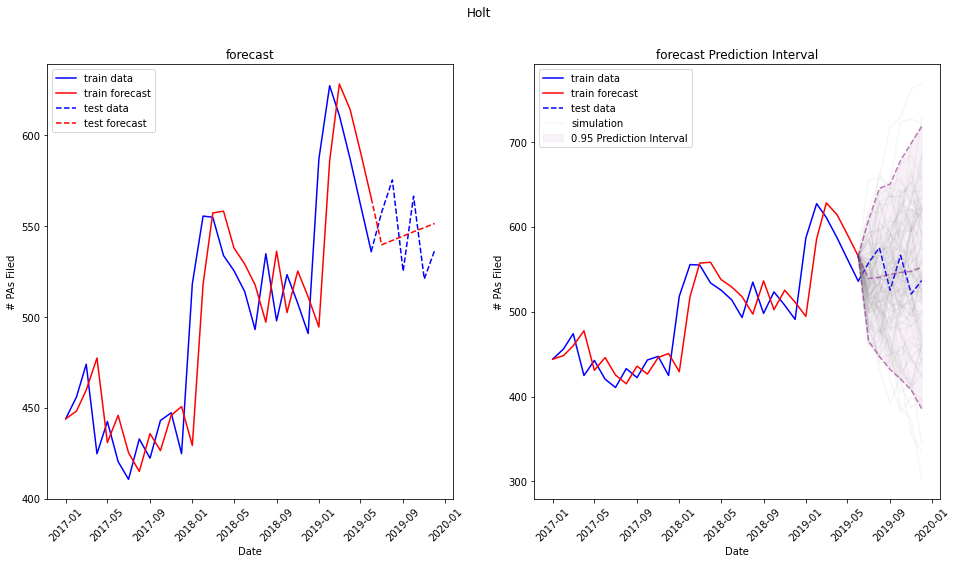

In [625]:
fit_and_plot_both(Holt, damped_trend=True)
None

Train MSE for Holt: 1232.59
Test MSE for Holt: 1580.26
Upper Bound Prediction Interval MSE for Holt: 32646.94
Lower Bound Prediction Interval MSE for Holt: 12606.18

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 25.04 % of the true # of PAs filed monthly.


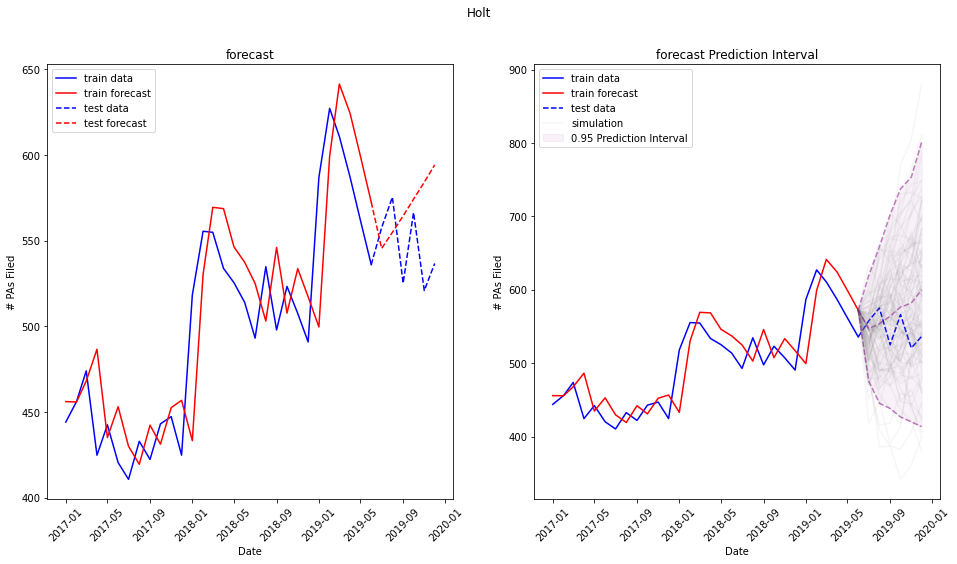

In [626]:
fit_and_plot_both(Holt, damped_trend=False, exponential = True)

Train MSE for Holt: 1121.29
Test MSE for Holt: 1177.75
Upper Bound Prediction Interval MSE for Holt: 16360.19
Lower Bound Prediction Interval MSE for Holt: 17211.55

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 22.15 % of the true # of PAs filed monthly.


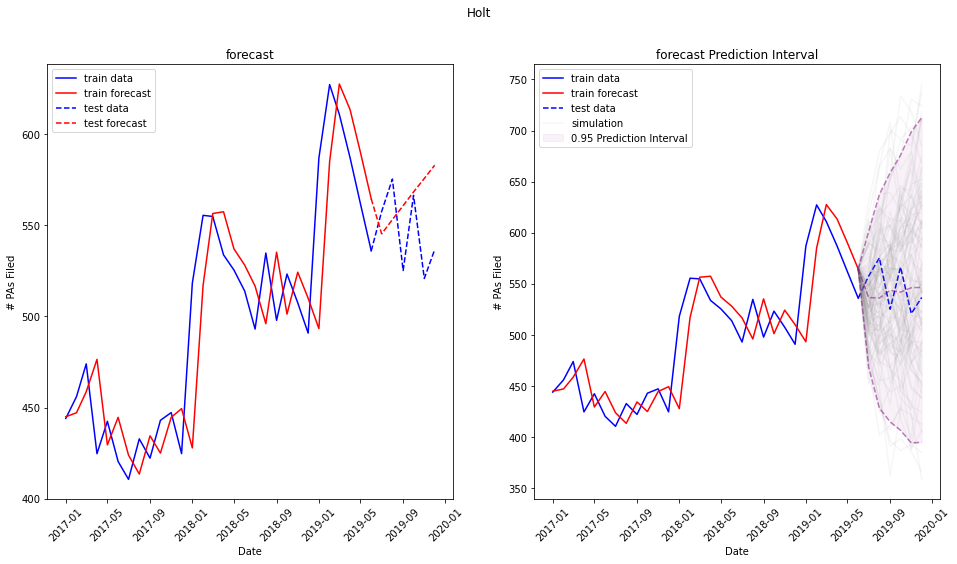

In [627]:
fit_and_plot_both(Holt, damped_trend=True, exponential = True)

### Exponential Smoothing
The previous two models are both exponential smoothing models but do not encapsulate seasonality. Now we work with the full exponential smoothing model, in which an extra equation is added to ecapusalte seasonal patterns in the data. See the appendix for more information. 

**We find that the model using an additive damped trend and additive seasonality give us the best results**

Train MSE for ExponentialSmoothing: 1232.59
Test MSE for ExponentialSmoothing: 1580.26
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 28576.64
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 14669.05

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 24.8 % of the true # of PAs filed monthly.


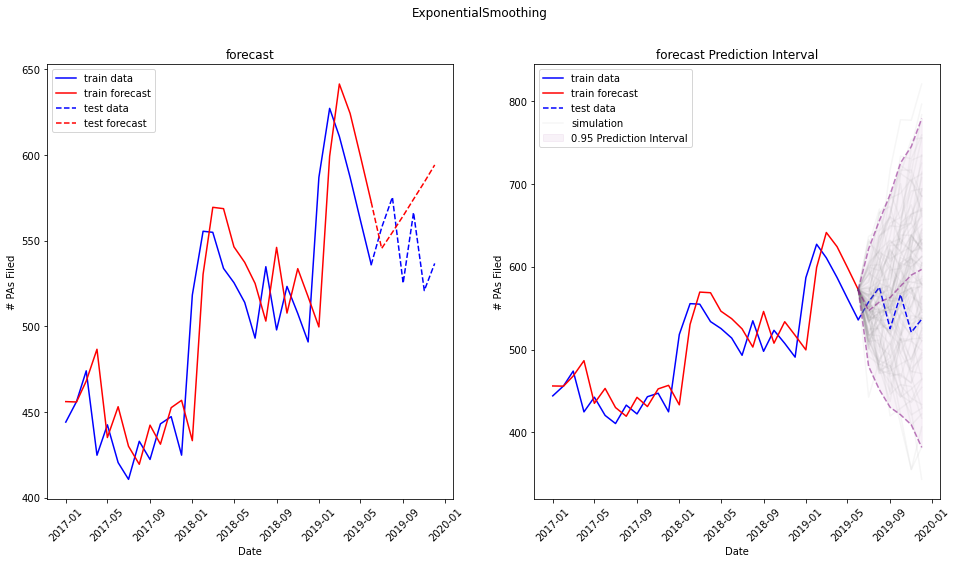

In [628]:
fit_and_plot_both(ExponentialSmoothing, trend='mul')
None

Train MSE for ExponentialSmoothing: 85.75
Test MSE for ExponentialSmoothing: 391.29
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 1954.08
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 1525.32

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 7.12 % of the true # of PAs filed monthly.


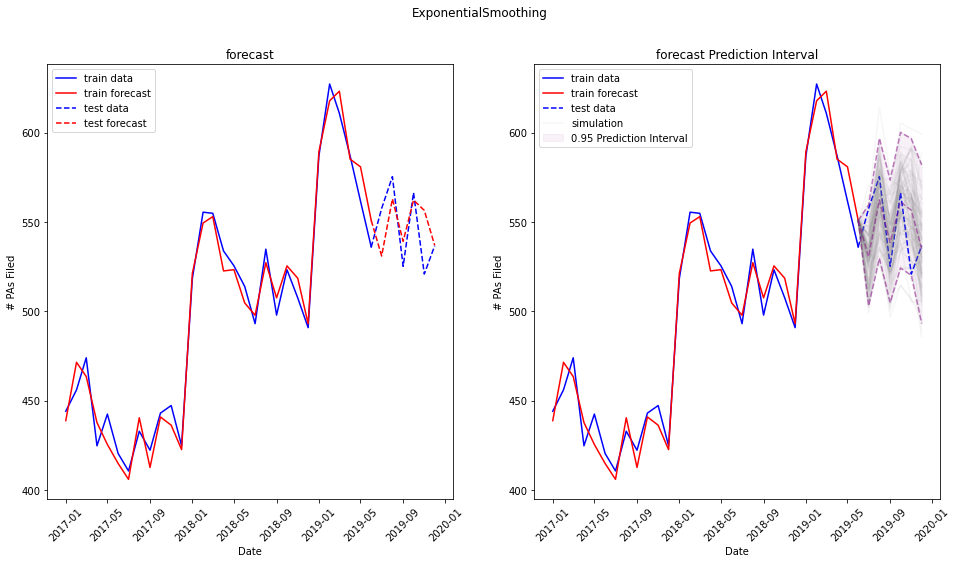

In [629]:
fit_and_plot_both(ExponentialSmoothing, alpha=.95, trend='add', seasonal='add', seasonal_periods=12)

Train MSE for ExponentialSmoothing: 63.18
Test MSE for ExponentialSmoothing: 276.43
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 828.87
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 912.72

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 5.04 % of the true # of PAs filed monthly.


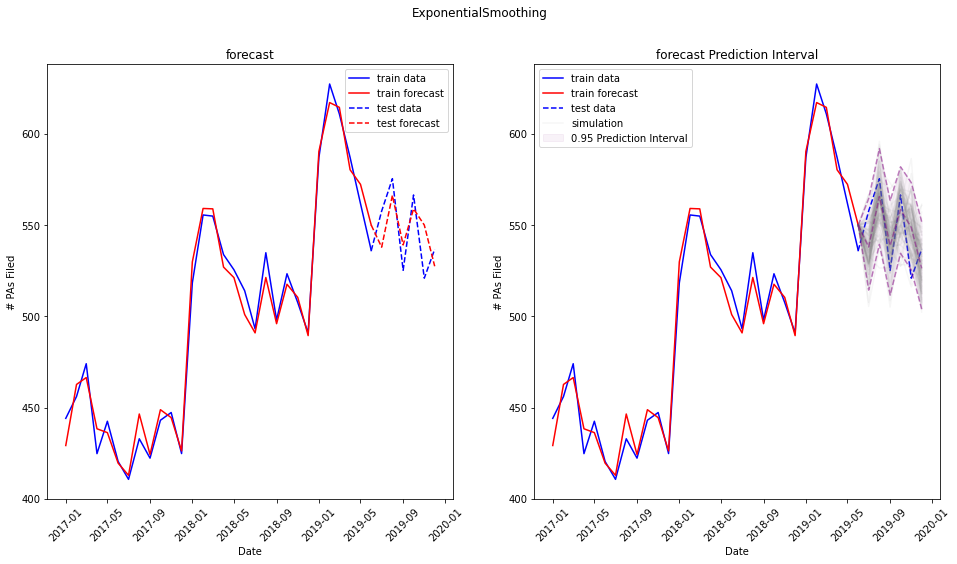

In [630]:
fit_and_plot_both(
    ExponentialSmoothing, 
    trend='add', damped_trend=True,
    seasonal='add', seasonal_periods=12
)


Train MSE for ExponentialSmoothing: 85.75
Test MSE for ExponentialSmoothing: 391.29
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 1763.81
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 1496.63

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 6.9 % of the true # of PAs filed monthly.


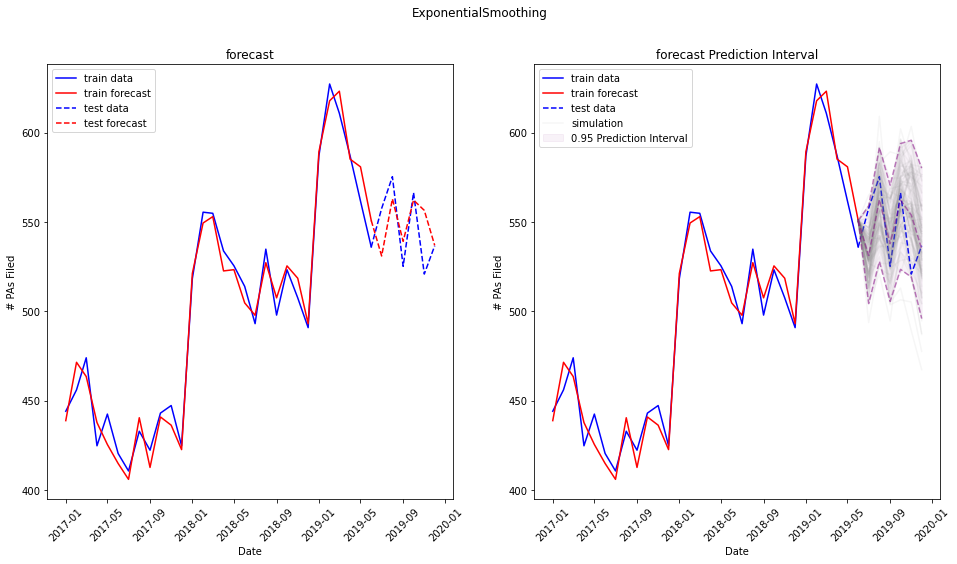

In [631]:
fit_and_plot_both(
    ExponentialSmoothing, alpha=.95,
    trend='add', damped_trend=False,
    seasonal='add', seasonal_periods=12
)

Train MSE for ExponentialSmoothing: 79.31
Test MSE for ExponentialSmoothing: 402.58
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 1605.42
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 1733.96

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 6.98 % of the true # of PAs filed monthly.


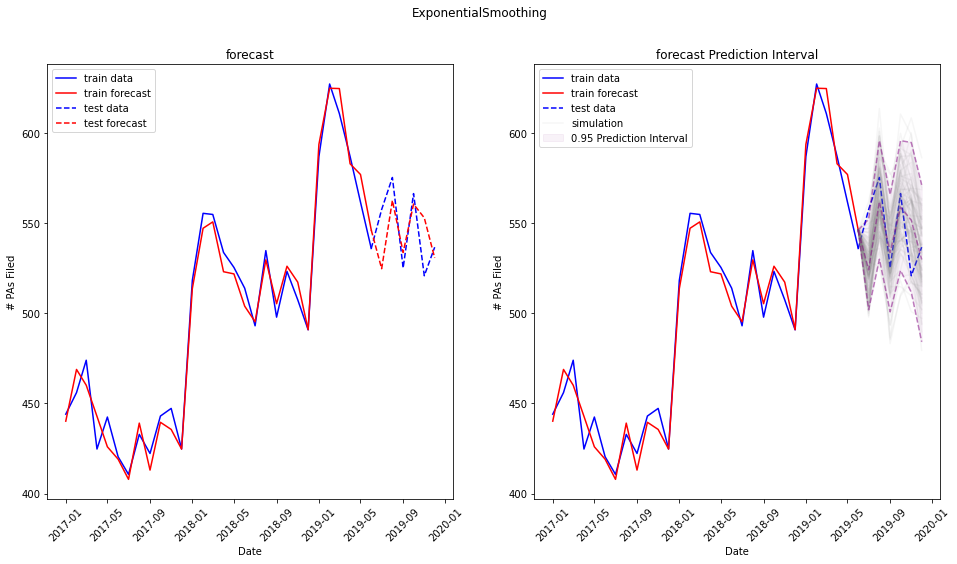

In [632]:
fit_and_plot_both(
    ExponentialSmoothing,
    trend='mul',
    seasonal='mul', damped=False, seasonal_periods=12, alpha = .95
)

Train MSE for ExponentialSmoothing: 67.19
Test MSE for ExponentialSmoothing: 786.58
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 678.29
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 2069.46

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 6.12 % of the true # of PAs filed monthly.


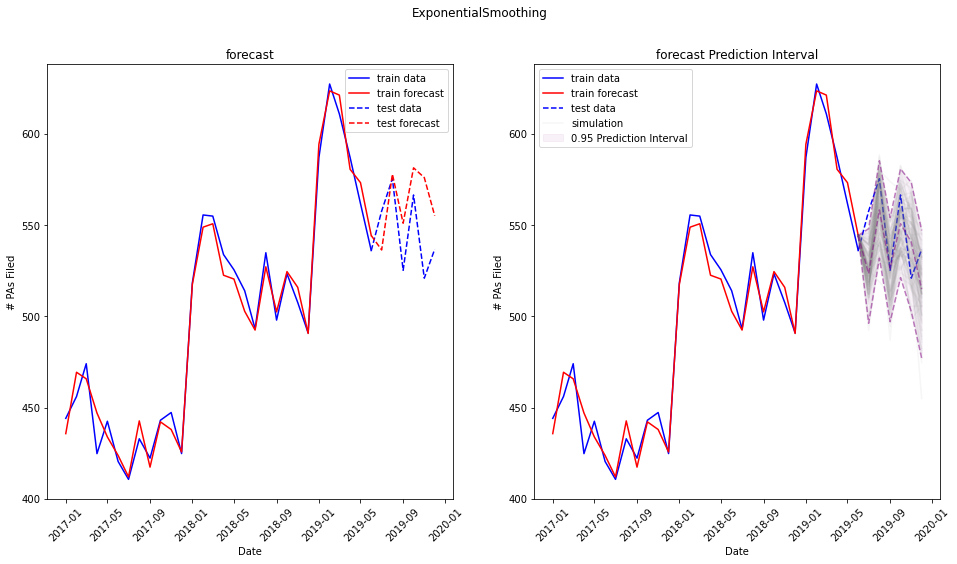

In [633]:
fit_and_plot_both(
    ExponentialSmoothing,
    trend='mul',
    seasonal='mul', damped=True, seasonal_periods=12, alpha = .95
)

### ARIMA
The last approach to time series forecasting we take is via the ARIMA model. While exponential smoothing models aim to describe the seasonality and trends in the data, the ARIMA model seeks to capture the autocorrelations of the data. 

See the appendix for the mathematics of this model. 

In [634]:
from statsmodels.tsa.arima.model import ARIMA

Train MSE for ARIMA: 79364.17
Test MSE for ARIMA: 202.82
Upper Bound Prediction Interval MSE for ARIMA: 14246.53
Lower Bound Prediction Interval MSE for ARIMA: 14167.17

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 20.38 % of the true # of PAs filed monthly.


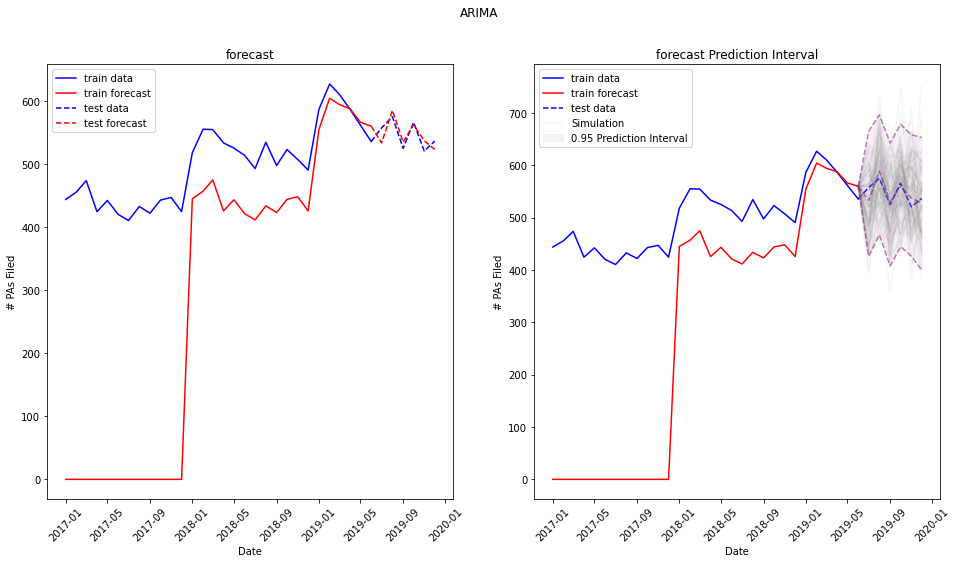

In [635]:
fit_and_plot_both(ARIMA, seasonal_order=(0, 1, 1, 12))

## Cross Validation
In this section we perform cross validation on the exponential smoothing and ARIMA models to determine the best parameters. In order to construct the cross validation splits, we chooose $k \in \{24, \dots, 30\}$. Our training set is the set of months from $1$ to $k$ and the forcast region is the next $6$ months after month $k$. We will compute the mean squared error on these sets for all possible parameter combinations. 

In [636]:
import itertools

def check_param(param, param_list):
    if param['trend'] is None and param['damped_trend']:
        return
    if param['seasonal'] is None and param['seasonal_periods'] is not None:
        return
    if param['seasonal'] is not None and param['seasonal_periods'] is None:
        return
    param_list.append(param)

def get_param_list(param_grid):
    keys = list(param_grid.keys())
    vals = [param_grid[k] for k in keys]
    params = list(dict(zip(keys, param)) for param in itertools.product(*vals))
    ret = []
    for param in params:
        check_param(param, ret)
    return ret

### CV: Exponential Smoothing
We first gather all of the possible parameters form exponetial smoothing. 

In [637]:
param_grid = {
    'trend': [None, 'add', 'mul'],
    'damped_trend': [False, True],
    'seasonal': [None, 'add', 'mul'],
    'seasonal_periods': [None, 3, 6, 9, 12]
}


param_list = get_param_list(param_grid)
idx = np.arange(30)
splits = [
    (idx[:k], idx[k:k+6])
    for k in range(24, 30)
]

We next 

In [638]:
mses = np.zeros((len(splits), len(param_list)))

for i, (train_idx, test_idx) in enumerate(splits):
    xx_train, xx_test = X_train[train_idx], X_train[test_idx]
    for j, param in enumerate(param_list):
        fit = ExponentialSmoothing(xx_train, **param).fit(optimized=True)
        mses[i, j] = mean_squared_error(xx_test, fit.forecast(len(xx_test)))

In [639]:
mean_mses = np.mean(mses, axis=0)

In [640]:
k = mean_mses.argmin()
print(f'Best parameters: {param_list[k]}')

Best parameters: {'trend': None, 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 12}


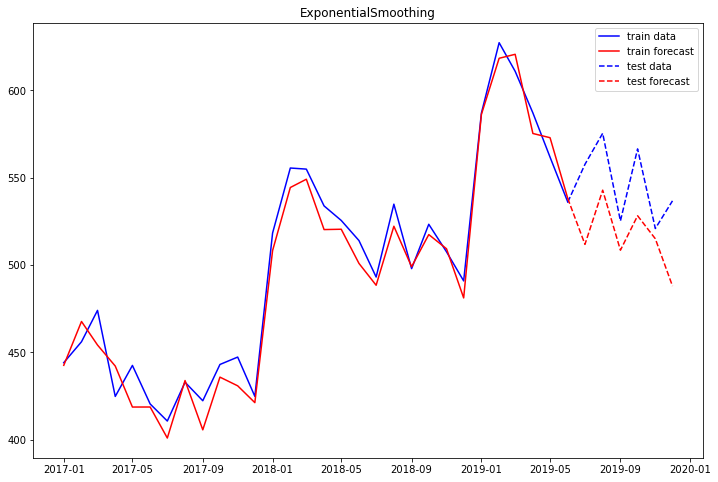

Train MSE for ExponentialSmoothing: 116.95
Test MSE for ExponentialSmoothing: 1219.92


In [641]:
fit_model_and_plot(ExponentialSmoothing, **param_list[k])
None

Train MSE for ExponentialSmoothing: 116.95
Test MSE for ExponentialSmoothing: 1219.92
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 566.25
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 7170.76

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 9.28 % of the true # of PAs filed monthly.


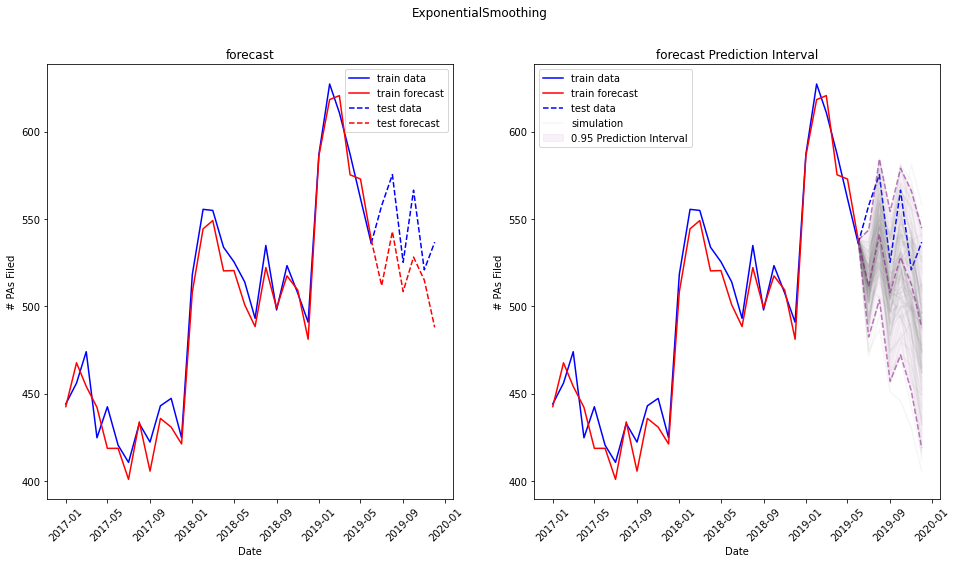

In [642]:
fit_and_plot_both(
    ExponentialSmoothing,
    **param_list[k], alpha = .95
)

Cross validation gives a very different set of parameters than our own explorations.

|  | Cross Validation | Exploration |
| --- | --- | --- |
| trend | None | add |
| damped_trend | False | True |
| seasonal | mul | add |
| seasonal_periods | 3 | 12 |
| train MSE | 5569.60 | 331.03 |
| test MSE | 1718.76 | 1069.72 |

This could be because our explorations in the previous section focused on minimizing the mean squared error on the forcast region only (months 31-36); so we chose the best model for the forcast region. In comparison, the cross validation procedure uses the last year of data as the test set and so finds a model that best forcasts 6 month intervals within the entire last year.

### CV: ARIMA
We now perform cross validation on the ARIMA model. 

In [643]:
param_list = list(
    itertools.product(
        range(0, 2), # P
        range(0, 2), # D
        range(0, 2), # Q
        [3, 6, 9, 12], # S
    )
)
idx = np.arange(30)
splits = [
    (idx[:k], idx[k:k+3])
    for k in range(24, 30)
]

mses = np.zeros((len(splits), len(param_list)))

for i, (train_idx, test_idx) in enumerate(splits):
    xx_train, xx_test = X_train[train_idx], X_train[test_idx]
    for j, param in enumerate(param_list):
        fit = ARIMA(xx_train, seasonal_order=param).fit()
        mses[i, j] = mean_squared_error(xx_test, fit.forecast(len(xx_test)))
mses = mses.mean(axis=1)

In [644]:
k = mses.argmin()
print(f'The best parameters for seasonal_order in ARIMA: {param_list[k]}')

The best parameters for seasonal_order in ARIMA: (0, 0, 1, 6)


Train MSE for ARIMA: 3565.44
Test MSE for ARIMA: 1294.60
Upper Bound Prediction Interval MSE for ARIMA: 7392.54
Lower Bound Prediction Interval MSE for ARIMA: 22045.22

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 20.04 % of the true # of PAs filed monthly.


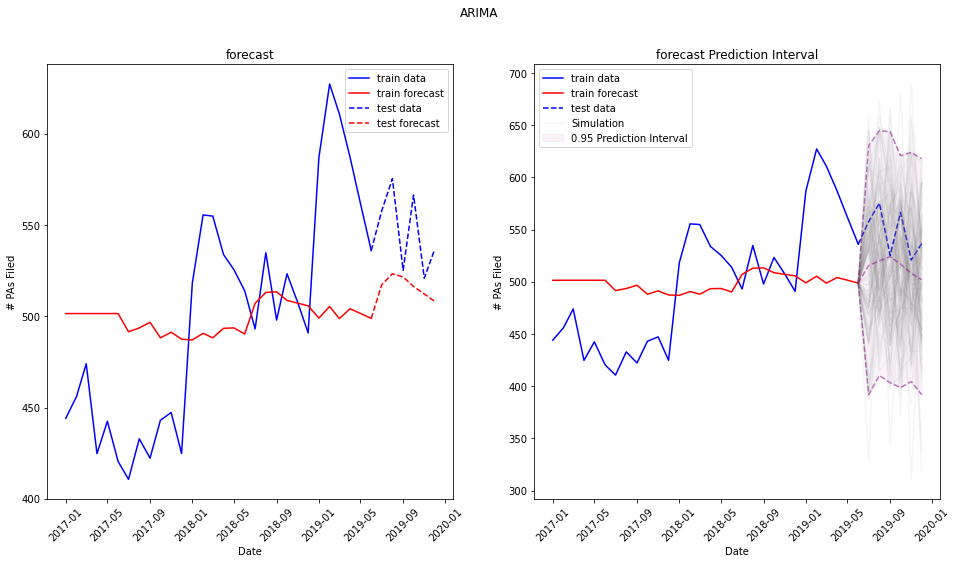

In [645]:
fit_and_plot_both(ARIMA, alpha=.95, seasonal_order=param_list[k])
None

## Appendix: the Mathematics Behind the Models
Here we include a brief mathematical discussion of the above models. 

### Exponential Smoothing 
Simple exponential smoothing, Holt's method, and exponential smoothing as discussed above are all variations of the same model using different combinations of trends and seasonal components. The parameters for `ExponentialSmoothing()` determine the form of the particular model by adjusting the governing equations. 

In general, every exponential smoothing model consists of a forcast equation and a level equation, given by $\hat x$ and $\ell$ respectively: 
\begin{align*} \hat x_{t + h | t} & = \ell_t + h b_t \\
\ell_t&  = \alpha x_t + (1-\alpha)(\ell_{t-1}).
\end{align*}

Note that this is precisely the equation discussed in the simple exponential smoothing section. If we want to encapsulate an additive trend, the above equations are modified and a third is added: 
\begin{align*} \hat x_{t + h | t} & = \ell_t + h b_t \\
\ell_t& = \alpha x_t + (1-\alpha)(\ell_{t-1} + b_t) \\
b_t & = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*)b_{t-1}.
\end{align*}
The equation for $b_t$ is called the trand equation and $\beta*$ is the smoothing parameter for the trend. This modification means that the forcast function is no longer flat but is instead increasing or decreasing. 

If we want to dampen the trend, we simply add a damping parameter $\phi$ with $0 < \phi < 1$ to obtain the equations
\begin{align*} \hat x_{t + h | t} & = \ell_t + (\phi+\phi^2 + \dots + \phi^h) b_t \\
\ell_t& = \alpha x_t + (1-\alpha)(\ell_{t-1} + \phi b_t) \\
b_t & = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*)\phi b_{t-1}.
\end{align*}
If $\phi = 1$ then the trend is undamped.

If we want to add seasonality, we add an extra equation $s_t$ in a way similar to the addition of the trend equation. 

Lastly, the difference between an additive and a multiplicative trend or seasonaility refers to the operation in the equations and captures the amount of growth in the model. For example, an additive trend grows linearly whereas a multiplicative trend grows exponentially in time. See [1] for more. 

### ARIMA

First, define the change between consecutive observations in the series to be 
$$ x_t' = y_t - x_{t-1}.$$
This is referred to a differenced term and $\{x'_t\}$ is called the differenced series. Then the non-seasonal ARIMA model can be written as 
$$ x_t' = c + \phi_1 {y'}_{t-1} + \dots + \phi_p {y'}_{t-p} + \theta_1\epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t.$$
The parameter $p$ gives the order of the autoregressive part, $d$ gives the degree of first differencing involved and $q$ is the order of the moving average. If we want to make this model seasonal, we add terms virtually identical to those above to predict $x_t'$ only the backshifts involved in the differenced terms correspond to the seasonal period. 

**References**

[1] Hyndman, Rob J., and George Athanasopoulos. *Forecasting: principles and practice.* OTexts, 2014

# Daily Volume Prediction
In the following section of this notebook, we discuss two different methods to make predictions on daily PA volume for 2019 given the PA volume data of 2017 and 2018.

In [1]:
import os
import math, datetime, itertools
import pandas as pd
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

sns.set_theme(style='whitegrid')
sns.set_palette("Paired")

In [2]:
pal = sns.husl_palette(20, h=.6)

## Data Preparation

### Read all data

In [3]:
data_folder = '../data/'
def path_for(filename, folder=data_folder):
    return os.path.join(folder, filename)

df_date = pd.read_csv(path_for('dim_date.csv'))
df_pa = pd.read_csv(path_for('dim_pa.csv'))
df_bridge = pd.read_csv(path_for('bridge.csv'))

In [4]:
df_date.head(3)

,dim_date_id,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,2017-01-01,2017,1,1,1,0,0,1
1,2,2017-01-02,2017,1,2,2,1,0,0
2,3,2017-01-03,2017,1,3,3,1,1,0


In [5]:
df_pa.head(3)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1,1,0,1
1,2,1,0,0,1
2,3,0,0,1,1


In [6]:
df_bridge[df_bridge['dim_pa_id'] > 0].head(10)

,dim_claim_id,dim_pa_id,dim_date_id
0,1,1.0,1
2,3,2.0,1
9,10,3.0,1
10,11,4.0,1
14,15,5.0,1
15,16,6.0,1
17,18,7.0,1
19,20,8.0,1
20,21,9.0,1
21,22,10.0,1


### Merge dataframes

In [7]:
df = pd.merge(df_pa, df_bridge, on = 'dim_pa_id')

In [8]:
df.head(3)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,dim_claim_id,dim_date_id
0,1,1,1,0,1,1,1
1,2,1,0,0,1,3,1
2,3,0,0,1,1,10,1


In [9]:
df = df.merge(df_date, on = 'dim_date_id')

In [10]:
df.head(3)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,dim_claim_id,dim_date_id,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,1,1,0,1,1,1,2017-01-01,2017,1,1,1,0,0,1
1,2,1,0,0,1,3,1,2017-01-01,2017,1,1,1,0,0,1
2,3,0,0,1,1,10,1,2017-01-01,2017,1,1,1,0,0,1


In [11]:
df.columns

Index(['dim_pa_id', 'correct_diagnosis', 'tried_and_failed',
       'contraindication', 'pa_approved', 'dim_claim_id', 'dim_date_id',
       'date_val', 'calendar_year', 'calendar_month', 'calendar_day',
       'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
      dtype='object')

In [12]:
df = df.drop(['dim_pa_id', 'correct_diagnosis', 'tried_and_failed',
       'contraindication', 'pa_approved', 'dim_claim_id', 'dim_date_id'], axis = 1)

In [13]:
df.columns

Index(['date_val', 'calendar_year', 'calendar_month', 'calendar_day',
       'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
      dtype='object')

### Plots of weekly data
We look at plots of normalized PA volume data by year. We will be able to observe some common tendencies in PA volume within a year.

In [14]:
# Add calendar week
df['calendar_week'] = df.apply(lambda row: datetime.date(row['calendar_year'], row['calendar_month'], row['calendar_day']).isocalendar()[1], axis=1)

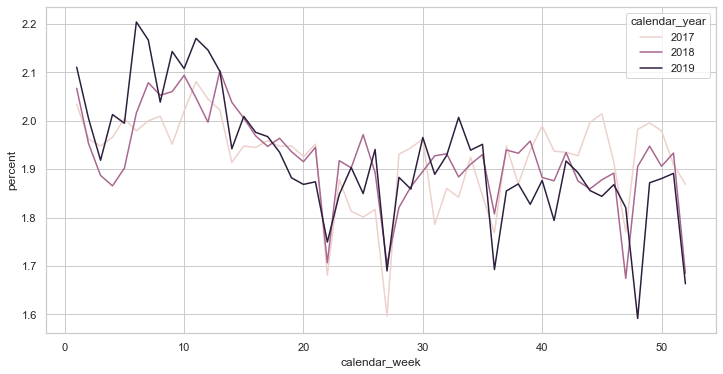

In [15]:
# Plot PA by week
fig, ax = plt.subplots(figsize=(12, 6))

df_weekly = df.groupby('calendar_year')['calendar_week'].value_counts(normalize=True)
df_weekly = df_weekly.mul(100)
df_weekly = df_weekly.rename('percent').reset_index()

lp = sns.lineplot(x = 'calendar_week', y = 'percent', hue='calendar_year', data= df_weekly, ax = ax)

In [16]:
df = df.drop(['calendar_week'], axis = 1)

### More prep

In [17]:
# Save this for later.
vol_2017 = df[df['calendar_year'] == 2017].groupby('calendar_year')['date_val'].value_counts().sum()
vol_2018 = df[df['calendar_year'] == 2018].groupby('calendar_year')['date_val'].value_counts().sum()
vol_2019 = df[df['calendar_year'] == 2019].groupby('calendar_year')['date_val'].value_counts().sum()

vol_dict = dict([(2017, vol_2017), (2018, vol_2018), (2019, vol_2019)])
df_vol = pd.DataFrame([[2017, vol_2017], [2018, vol_2018], [2019, vol_2019]], columns = ['calendar_year', 'volume'])

In [18]:
vol_dict

{2017: 159438, 2018: 190011, 2019: 206502}

In [19]:
df_vol = pd.DataFrame(data = df.groupby('date_val')['date_val'].count().rename('daily_vol')).reset_index()
df_vol

,date_val,daily_vol
0,2017-01-01,94
1,2017-01-02,437
2,2017-01-03,614
3,2017-01-04,591
4,2017-01-05,598
...,...,...
1090,2019-12-27,682
1091,2019-12-28,262
1092,2019-12-29,207
1093,2019-12-30,596


In [20]:
df_per = df.groupby('calendar_year')['date_val'].value_counts(normalize=True).mul(100).rename('daily_per').reset_index()
df_per

,calendar_year,date_val,daily_per
0,2017,2017-11-28,0.396392
1,2017,2017-03-23,0.393256
2,2017,2017-05-11,0.388866
3,2017,2017-12-06,0.386357
4,2017,2017-01-03,0.385103
...,...,...,...
1090,2019,2019-12-08,0.102662
1091,2019,2019-06-08,0.101694
1092,2019,2019-12-29,0.100241
1093,2019,2019-09-22,0.097820


In [21]:
df = df.drop_duplicates()
df = df.merge(df_vol, how = 'left', on = 'date_val')
df = df.merge(df_per[['date_val', 'daily_per']], how = 'left', on = 'date_val')

In [22]:
df.corr()['daily_vol'].sort_values()

is_holiday       -0.161851
calendar_month   -0.073604
calendar_day      0.003542
day_of_week       0.037934
calendar_year     0.260435
is_weekday        0.911305
is_workday        0.931678
daily_per         0.959167
daily_vol         1.000000
Name: daily_vol, dtype: float64

### Useful definitions

In [23]:
def error(actual, prediction):
    return abs(prediction - actual)

def mae(actual, prediction, rounding = 5):
    errors = error(actual, prediction)
    return round(np.mean(errors), rounding)

def accuracy(actual, prediction, rounding = 5):
    errors = error(actual, prediction)
    return 100 - 100 * np.mean((errors / actual))

def rmse(actual, prediction, rounding = 5):
    errors = error(actual, prediction)
    return round(mean_squared_error(actual, prediction, squared = False), rounding)

def measure(actual, prediction, rounding = 5):
    return (mae(actual, prediction, rounding), accuracy(actual, prediction, rounding), rmse(actual, prediction, rounding))

## Random forest regressor
The approach in this section was inspired by the approach in the following article: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0. Given multiple features relating to dates, we explore how these features correlate with daily PA volume and make predictions using a random forest regressor.

In [24]:
class RegressionData():
  def __init__(self, train_df, test_df, features, labels):
    
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    self.train_labels = np.array(train_df[labels]).ravel()
    self.train_features = np.array(train_df[features])
    self.test_labels = np.array(test_df[labels]).ravel()
    self.test_features = np.array(test_df[features])
      
    self.features = features
    self.labels = labels
    
  def fit(self, regressor):
    regressor.fit(self.train_features, self.train_labels)

  def predict(self, regressor):
    return regressor.predict(self.test_features)

  def get_actual(self):
    return self.test_labels

  def __repr__(self):
    return '\n'.join([
        f'Features : {self.features}',
        f'Labels: {self.labels}',
        f'Train set size: {self.train_labels.shape[0]}',
        f'Test set size: {self.test_labels.shape[0]}'])

In [25]:
# This is the dataset that will be used for the following regressions.
rf_data = RegressionData(df[df['calendar_year'] < 2019], df[df['calendar_year'] == 2019], 
                        ['calendar_month', 'calendar_day', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
                        ['daily_per'])
print(rf_data)

Features : ['calendar_month', 'calendar_day', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday']
Labels: ['daily_per']
Train set size: 730
Test set size: 365


In [26]:
actual = rf_data.get_actual()
actual = actual*vol_dict[2019]*0.01

In [27]:
# Regressor to be used
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [28]:
# Fit.
rf_data.fit(rf)

In [29]:
# Predict.
predictions = rf_data.predict(rf)*vol_dict[2019]*0.01;

In [30]:
# Check the prediction.

# Calculate the mean absolute errors (MAE)
print('Mean Absolute Error:', mae(actual, predictions))

# Calculate the mean absolute percentage error (MAPE)
print('Accuracy:', accuracy(actual, predictions), '%.')

# Calculate the root mean squared error (RMSE)
print('Mean Squared Error:', rmse(actual, predictions))

Mean Absolute Error: 28.33868
Accuracy: 94.74212322739032 %.
Mean Squared Error: 37.77913


In [31]:
# Label importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(rf_data.features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: is_workday           Importance: 0.94
Variable: day_of_week          Importance: 0.02
Variable: calendar_month       Importance: 0.01
Variable: calendar_day         Importance: 0.01
Variable: is_weekday           Importance: 0.01
Variable: is_holiday           Importance: 0.01


In [32]:
# Permutation feature importance
r = permutation_importance(rf, rf_data.test_features, rf_data.test_labels, n_repeats = 30, random_state = 42)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{rf_data.features[i]:<8}"
          f" {r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

is_workday 0.887 +/- 0.049
is_weekday 0.500 +/- 0.028
is_holiday 0.029 +/- 0.001
day_of_week 0.028 +/- 0.004
calendar_month 0.015 +/- 0.002
calendar_day 0.003 +/- 0.001


In [33]:
n_repeats = 50

preds = []
maes = []
accs = []
rmses = []

data = rf_data
for repeats in range(n_repeats):   
    
    data.fit(rf)
    prediction = data.predict(rf);
    prediction = prediction*vol_dict[2019]*0.01
    
    preds.append(prediction.reshape(-1))
    measures = measure(actual, prediction)
    maes.append(measures[0])
    accs.append(measures[1])
    rmses.append(measures[2])
    
preds = np.array(preds)
maes = np.array(maes)
accs = np.array(accs)
rmses = np.array(rmses)

# Print measures.
print('MAE averaged over ', n_repeats, 'reps : ', np.mean(maes))
print('Accuracy averaged over ', n_repeats, 'reps : ', np.mean(accs))
print('RMSE averaged over ', n_repeats, 'reps : ', np.mean(rmses))

# Assume normal distribution.
mean = np.mean(preds, axis=0).reshape(-1)
std = np.std(preds, axis=0).reshape(-1)
lower = np.percentile(preds, 5, axis=0).reshape(-1)
upper = np.percentile(preds, 95, axis=0).reshape(-1)

# Print std.
print(f'Max and Mean standard deviation are: {np.amax(std)} and {np.mean(std)}')

MAE averaged over  50 reps :  28.338680000000004
Accuracy averaged over  50 reps :  94.74212322739031
RMSE averaged over  50 reps :  37.77913
Max and Mean standard deviation are: 1.0231815394945443e-12 and 3.166879239820633e-13


### Random forest without calendar_day
Pemutation importance suggest 'calendar_day' might be of very little importance. Try omitting it and see if prediction improves. A minute improvement will be observed and data with 'calendar_day' omitted will be used after this section unless specifically noted otherwise.

In [34]:
rf_data_no_day = RegressionData(df[df['calendar_year'] < 2019], df[df['calendar_year'] == 2019], 
                        ['calendar_month', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
                        ['daily_per'])
print(rf_data)

Features : ['calendar_month', 'calendar_day', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday']
Labels: ['daily_per']
Train set size: 730
Test set size: 365


In [35]:
n_repeats = 50

preds = []
maes = []
accs = []
rmses = []

data = rf_data_no_day
for repeats in range(n_repeats):   
    
    data.fit(rf)
    prediction = data.predict(rf);
    prediction = prediction*vol_dict[2019]*0.01
    
    preds.append(prediction.reshape(-1))
    measures = measure(actual, prediction)
    maes.append(measures[0])
    accs.append(measures[1])
    rmses.append(measures[2])
    
preds = np.array(preds)
maes = np.array(maes)
accs = np.array(accs)
rmses = np.array(rmses)

# Print measures.
print('MAE averaged over ', n_repeats, 'reps : ', np.mean(maes))
print('Accuracy averaged over ', n_repeats, 'reps : ', np.mean(accs))
print('RMSE averaged over ', n_repeats, 'reps : ', np.mean(rmses))

# Assume normal distribution.
mean = np.mean(preds, axis=0).reshape(-1)
std = np.std(preds, axis=0).reshape(-1)
lower = np.percentile(preds, 5, axis=0).reshape(-1)
upper = np.percentile(preds, 95, axis=0).reshape(-1)

# Print std.
print(f'Max and Mean standard deviation are: {np.amax(std)} and {np.mean(std)}')

MAE averaged over  50 reps :  27.90612
Accuracy averaged over  50 reps :  94.74846738347179
RMSE averaged over  50 reps :  36.70955000000001
Max and Mean standard deviation are: 1.0231815394945443e-12 and 2.9184812861686085e-13


### Prediction Intervals
The codes and the approach here are adopted form the following blog post: https://medium.com/dataman-in-ai/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-d3c651af7516. The idea is to look at prediction made by each decision tree regressor.

In [36]:
rf_q = RandomForestRegressor(n_estimators=200, random_state=0,min_samples_split=10)
rf_data_no_day.fit(rf_q)

In [37]:
upper, lower = 0.95, 0.05

In [38]:
# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
pred_q = pd.DataFrame()

# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
for estimator in rf.estimators_:
    temp = pd.Series(rf_data_no_day.predict(estimator)*vol_dict[2019]*0.01)
    pred_q = pd.concat([pred_q, temp], axis = 1)


In [39]:
pred_q

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,282.350732,282.350732,270.610638,286.717936,270.610638,270.610638,282.350732,270.610638,270.610638,270.610638,...,270.610638,288.826666,280.391746,282.500476,270.610638,288.826666,270.610638,280.391746,270.610638,270.610638
1,714.815695,719.930753,695.921340,731.345427,741.202288,727.673078,715.101279,710.803011,726.736769,742.036971,...,713.710330,718.687924,737.266592,728.389305,712.906714,714.633154,731.426625,686.940336,705.821129,715.047627
2,733.098830,746.683180,724.269883,760.922271,740.170227,734.611543,720.908106,741.388887,721.694481,734.793542,...,724.346726,754.245587,736.716963,744.284765,700.845244,723.492923,715.291594,746.446192,729.330568,727.536701
3,705.924296,683.233374,701.144804,717.448001,682.191410,690.565424,691.510767,677.432254,688.080214,701.776562,...,700.729507,678.839001,720.029599,702.771156,679.326064,726.238498,698.584299,716.789271,690.558108,715.590731
4,247.710197,245.387357,251.444237,239.221920,244.439514,253.691392,249.645940,251.036158,246.010663,246.497904,...,247.587199,240.712569,247.677368,244.273463,237.431157,252.587720,251.826298,249.539332,230.399419,242.314080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,682.712381,668.055203,675.242531,682.118016,670.804952,682.191298,687.607116,677.914353,670.327716,675.287481,...,683.032338,680.196420,684.733559,679.630713,685.384745,676.176882,674.923721,686.445399,675.060243,674.801640
361,242.173857,232.232743,239.717276,241.195979,237.653228,234.292934,245.703589,237.856488,242.081021,239.836178,...,236.895312,237.969116,234.682708,236.634677,242.961867,240.371442,236.589956,237.839610,240.070615,234.644489
362,243.127978,244.448097,241.858445,249.376944,244.047441,240.515080,240.079695,242.471750,250.705744,239.963285,...,242.203117,241.802513,238.987817,251.956805,247.668163,243.218348,248.819884,243.422800,243.531731,236.797208
363,652.703687,650.935230,656.451094,655.331538,650.111248,657.610642,653.680377,651.052073,652.624943,660.789953,...,661.800563,650.942933,646.208538,657.913661,657.314585,656.418771,649.081833,649.848440,664.293870,650.521159


In [40]:
rf_actual_pred = pd.DataFrame()

for q in [upper, lower]:
    s = pred_q.quantile(q = q, axis = 1)
    rf_actual_pred = pd.concat([rf_actual_pred, s], axis = 1, sort = False)


In [41]:
rf_actual_pred

,0.95,0.05
0,288.826666,270.610638
1,740.592954,699.167155
2,754.566314,717.429033
3,723.087269,672.281924
4,253.809286,236.751344
...,...,...
360,691.784264,667.287447
361,243.791330,231.771519
362,251.520433,236.479342
363,665.910100,642.690249


In [42]:
rf_actual_pred['pred'] =  rf_data_no_day.predict(rf_q)*vol_dict[2019]*0.01
rf_actual_pred['actual'] = actual
rf_actual_pred['interval'] = rf_actual_pred[upper] - rf_actual_pred[lower]
rf_actual_pred

,0.95,0.05,pred,actual,interval
0,288.826666,270.610638,328.082633,341.0,18.216028
1,740.592954,699.167155,719.990930,735.0,41.425799
2,754.566314,717.429033,734.380921,748.0,37.137281
3,723.087269,672.281924,698.449288,744.0,50.805345
4,253.809286,236.751344,247.842905,244.0,17.057942
...,...,...,...,...,...
360,691.784264,667.287447,679.719543,682.0,24.496817
361,243.791330,231.771519,237.763612,262.0,12.019811
362,251.520433,236.479342,244.303371,207.0,15.041091
363,665.910100,642.690249,653.937514,596.0,23.219851


In [43]:
rf_actual_pred[(rf_actual_pred[0.95] <= rf_actual_pred['pred']) | (rf_actual_pred['pred'] <= rf_actual_pred[0.05]) ]

,0.95,0.05,pred,actual,interval
0,288.826666,270.610638,328.082633,341.0,18.216028
146,288.826666,270.610638,328.082633,241.0,18.216028
184,304.902038,282.350732,328.082633,294.0,22.551306
244,296.597787,271.697428,328.197155,290.0,24.900359
331,315.169017,295.606802,328.666143,263.0,19.562215
332,654.069356,577.085337,478.869033,567.0,76.984019
358,315.169017,284.147608,328.666143,344.0,31.021409


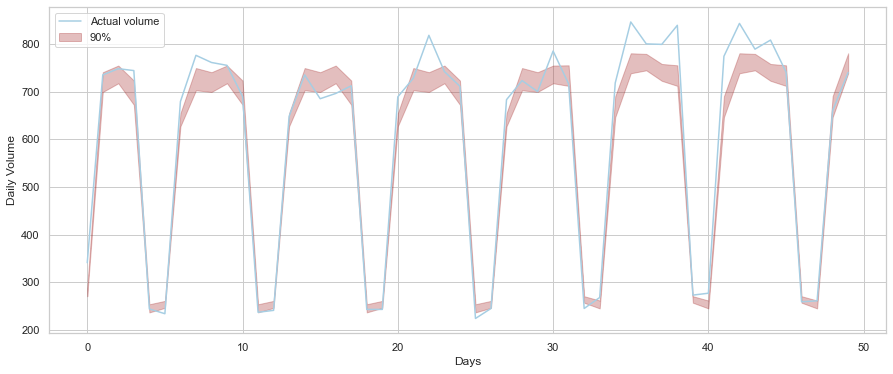

In [44]:
# Plotting with prediction interval.
days = 50

fig, ax = plt.subplots(figsize = (15,6))
ax.plot(rf_actual_pred['actual'][:days], label = 'Actual volume')
ax.fill_between(range(days), rf_actual_pred[0.95][:days], rf_actual_pred[0.05][:days], label='90%', color='brown', alpha=.3)
ax.set(ylabel = "Daily Volume", xlabel="Days")
ax.legend();

## RNN
We also use Long Short Term Memory (LSTM) model 

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

np.random.seed(7)

In [46]:
# Convert an array of values into a dataset matrix.
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [47]:
class RNNData():
  def __init__(self, dataset, train_size, look_back = 28): 
    # Store the raw data.
    self.train_size = train_size
    self.test_size = len(dataset) - train_size
    self.look_back = look_back
    
    self.original_dataset = dataset
    dataset = dataset.values.astype('float32')
    dataset = np.reshape(dataset, (-1,1))
    self.scaler = MinMaxScaler(feature_range = (0, 1))
    self.dataset = self.scaler.fit_transform(dataset)
    
    self.train, self.test = self.dataset[0:train_size,:], self.dataset[train_size:len(dataset),:]
    
    trainX, self.trainY = create_dataset(self.train, self.look_back)
    self.trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    
    testX, self.testY = create_dataset(self.test, self.look_back)
    self.testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  def fit_and_predict(self, epochs = 33, dropout = 0, batch_size = 1, verbose = 2):
    model = Sequential()
    model.add(LSTM(100, input_shape = (1, self.look_back)))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    model.fit(self.trainX, self.trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)
    pred = model.predict(self.testX)
    pred = self.invert(pred)
    return pred.T

  def invert(self, data):
    return self.scaler.inverse_transform(data)

  def get_actual(self):
    return self.invert([self.testY.reshape(-1)])

  def __repr__(self):
    return '\n'.join([
        f'Train X shape: {self.trainX.shape}',
        f'Train Y shape: {self.trainY.shape}',
        f'Test X shape: {self.testX.shape}',
        f'Test Y shape: {self.testY.shape}'])

In [48]:
rnn_data = RNNData(df['daily_vol'], 365*2, look_back = 28)
print(rnn_data)

Train X shape: (701, 1, 28)
Train Y shape: (701,)
Test X shape: (336, 1, 28)
Test Y shape: (336,)


In [49]:
prediction = rnn_data.fit_and_predict();

Epoch 1/33
701/701 - 19s - loss: 0.0122
Epoch 2/33
701/701 - 1s - loss: 0.0073
Epoch 3/33
701/701 - 1s - loss: 0.0064
Epoch 4/33
701/701 - 1s - loss: 0.0060
Epoch 5/33
701/701 - 1s - loss: 0.0058
Epoch 6/33
701/701 - 1s - loss: 0.0058
Epoch 7/33
701/701 - 1s - loss: 0.0056
Epoch 8/33
701/701 - 1s - loss: 0.0054
Epoch 9/33
701/701 - 1s - loss: 0.0057
Epoch 10/33
701/701 - 1s - loss: 0.0053
Epoch 11/33
701/701 - 1s - loss: 0.0053
Epoch 12/33
701/701 - 1s - loss: 0.0055
Epoch 13/33
701/701 - 1s - loss: 0.0053
Epoch 14/33
701/701 - 1s - loss: 0.0053
Epoch 15/33
701/701 - 1s - loss: 0.0052
Epoch 16/33
701/701 - 1s - loss: 0.0052
Epoch 17/33
701/701 - 1s - loss: 0.0050
Epoch 18/33
701/701 - 1s - loss: 0.0051
Epoch 19/33
701/701 - 1s - loss: 0.0049
Epoch 20/33
701/701 - 1s - loss: 0.0049
Epoch 21/33
701/701 - 1s - loss: 0.0051
Epoch 22/33
701/701 - 1s - loss: 0.0049
Epoch 23/33
701/701 - 1s - loss: 0.0050
Epoch 24/33
701/701 - 1s - loss: 0.0047
Epoch 25/33
701/701 - 1s - loss: 0.0048
Epoch 26

In [50]:
actual = rnn_data.get_actual()
actual.shape

(1, 336)

In [51]:
# Check the prediction.
errors = abs(prediction - actual)

# Calculate the mean absolute errors (MAE).
print('Mean Absolute Error:', mae(actual, prediction))

# Calculate the mean absolute percentage error (MAPE).
print('Accuracy:', accuracy(actual, prediction), '%.')

# Calculate the root mean squared error (RMSE)
print('Root Mean Squared Error:', rmse(actual, prediction))

Mean Absolute Error: 46.41266
Accuracy: 90.70613583799272 %.
Root Mean Squared Error: 46.41266


### Deciding on parameters
I adopted some ideas from the following article: https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/. Due to time constraint, I will only adjust the number of epoch and the drop out rate.

In [102]:
# Search for a (epoch, dropout) pair using RMSE.
epochs = [10, 20, 30, 40, 50]
dropouts = [0, 0.25, 0.5, 0.75]

configs = itertools.product(epochs, dropouts)

df_config = pd.DataFrame(columns = ['epoch', 'dropout', 'rmse_mean', 'rmse_std'])
n_reps = 10

for config in configs:
    rmses = []
    epoch, dropout = config[0], config[1]
    print(f'Starting reps for {epoch}, {dropout}')
    for i in range(n_reps):
        pred = rnn_data.fit_and_predict(epochs = epoch, dropout = dropout, verbose = 0)
        rmses.append(rmse(actual, pred))
    rmse_mean = np.mean(rmses)
    rmse_std = np.std(rmses)
    df_config.loc[len(df_config)] = [epoch, dropout, rmse_mean, rmse_std]
    

Starting reps for 10, 0
Starting reps for 10, 0.25
Starting reps for 10, 0.5
Starting reps for 10, 0.75
Starting reps for 20, 0
Starting reps for 20, 0.25
Starting reps for 20, 0.5
Starting reps for 20, 0.75
Starting reps for 30, 0
Starting reps for 30, 0.25
Starting reps for 30, 0.5
Starting reps for 30, 0.75
Starting reps for 40, 0
Starting reps for 40, 0.25
Starting reps for 40, 0.5
Starting reps for 40, 0.75
Starting reps for 50, 0
Starting reps for 50, 0.25
Starting reps for 50, 0.5
Starting reps for 50, 0.75


In [105]:
df_config

,epoch,dropout,rmse_mean,rmse_std
0,10.0,0.00,47.972457,6.089148
1,10.0,0.25,42.863919,4.585144
2,10.0,0.50,44.951337,9.497380
3,10.0,0.75,43.273529,7.491075
4,20.0,0.00,44.733118,9.620533
5,20.0,0.25,40.677954,1.718329
6,20.0,0.50,39.228550,2.371973
7,20.0,0.75,41.620150,4.933108
8,30.0,0.00,39.437737,3.080773
9,30.0,0.25,40.262859,5.671316


### Checking the performance of a LSTM Model
Now, we will calculate mean mae/accuracy/rmse after 100 repetitions. Looking at the mean of multiple repetitions is necessary since the prediction values from LSTM can vary due to the stochastic nature of the model.

Also, although the above data is certainly not conclusive due to a small number of repetition, (40, 0.0) looks pretty promising and we will use those configuration for this section. 

In [107]:
n_reps = 100

preds = []
maes = []
accs = []
rmses = []
for i in range(n_reps):
    pred = rnn_data.fit_and_predict(epochs = 40, dropout = 0, verbose = 0)
    preds.append(pred.reshape(-1))
    maes.append(mae(actual, pred))
    accs.append(accuracy(actual, pred))
    rmses.append(rmse(actual, pred))


In [108]:
preds = np.array(preds)
maes = np.array(maes)
accs = np.array(accs)
rmses = np.array(rmses)    
    
# Print measures.
print('MAE averaged over ', n_repeats, 'reps : ', np.mean(maes), ' with std ', np.std(maes))
print('Accuracy averaged over ', n_repeats, 'reps : ', np.mean(accs), ' with std ', np.std(accs))
print('RMSE averaged over ', n_repeats, 'reps : ', np.mean(rmses), ' with std ', np.std(rmses))

MAE averaged over  50 reps :  39.884971  with std  5.7424672349864565
Accuracy averaged over  50 reps :  91.43262208699116  with std  1.0412461422008823
RMSE averaged over  50 reps :  39.884971  with std  5.7424672349864565


In [120]:
# This is not prediction interval.

upper, lower = 0.95, 0.05

pred_upper = np.quantile(preds, upper, axis = 0)
pred_lower = np.quantile(preds, lower, axis = 0)

In [121]:
np.mean(abs(pred_upper-pred_lower))
np.std(pred_upper-pred_lower)

4.206192720940992

### Plotting of a LSTM Model
For the reason mentioned above, instead of plotting a single prediction, here we plot a range of predictions. Note this is not equal to the prediction interval.

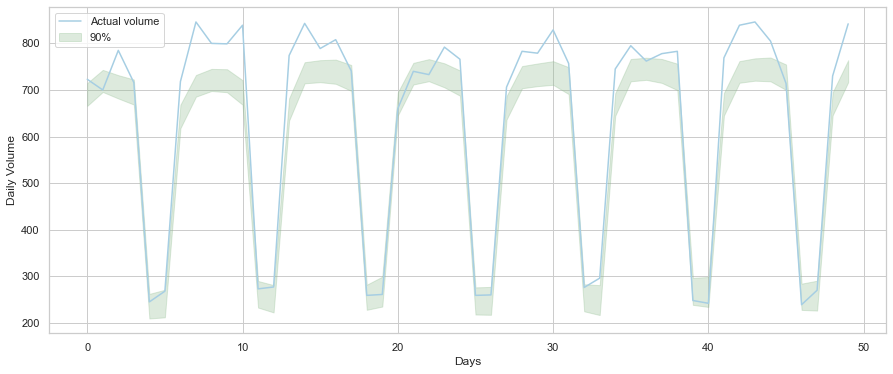

In [128]:
days = 50

fig, ax = plt.subplots(figsize = (15,6))

ax.plot(actual.reshape(-1)[:days], label = 'Actual volume')
ax.fill_between(range(days), pred_upper[:days], pred_lower[:days], label='90%', color='darkseagreen', alpha=.3)
ax.set(ylabel = "Daily Volume", xlabel="Days")
ax.legend();